In [ ]:
#install dependancies
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
#download dataset
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [ ]:
#3670 images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)#print no:images

3670


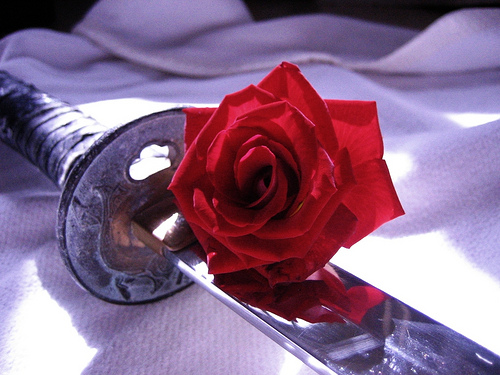

In [ ]:
roses = list(data_dir.glob('roses/*'))#add roses
PIL.Image.open(str(roses[0]))#shows an image of rose

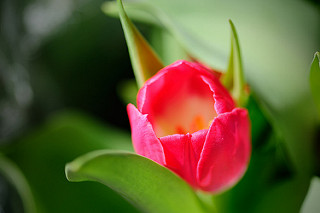

In [ ]:
tulips = list(data_dir.glob('tulips/*'))#add tulips
PIL.Image.open(str(tulips[0]))#shows tulips[0]

In [ ]:
#define parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
#splitting 80% of data to training and 20% to validation
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
#find the class names in the class_names attribute on these datasets in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


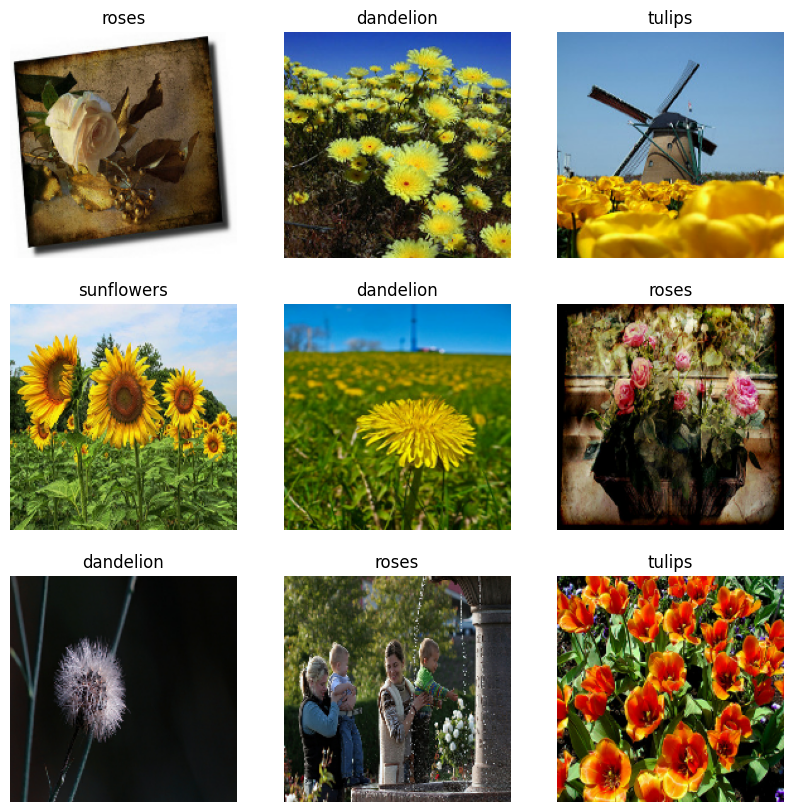

In [ ]:
#visualising first 9 images from the data.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):#9 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])#adding labels
    plt.axis("off")

In [ ]:
#The image_batch is a tensor of the shape (32, 180, 180, 3).
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
#keeps the images in memory after they're loaded off disk during the first epoch.
#This will ensure the dataset does not become a bottleneck while training your model.
#If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#The RGB channel values are in the [0, 255] range. This is not ideal for a neural network;
#In general you should seek to make your input values small.
#Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.008872573 0.7322078


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
# choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#View all the layers of the network using the Keras Model.summary method:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
#Train the model for 10 epochs with the Keras Model.fit method:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 16s 37ms/step - loss: 1.2837 - accuracy: 0.4547 - val_loss: 1.0932 - val_accuracy: 0.5286
Epoch 2/10
92/92 [==============================] - 2s 21ms/step - loss: 0.9764 - accuracy: 0.6202 - val_loss: 0.9792 - val_accuracy: 0.6294
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 0.7968 - accuracy: 0.6975 - val_loss: 0.9602 - val_accuracy: 0.6253
Epoch 4/10
92/92 [==============================] - 2s 21ms/step - loss: 0.6086 - accuracy: 0.7776 - val_loss: 0.9872 - val_accuracy: 0.6076
Epoch 5/10
92/92 [==============================] - 2s 20ms/step - loss: 0.4149 - accuracy: 0.8563 - val_loss: 0.8954 - val_accuracy: 0.6798
Epoch 6/10
92/92 [==============================] - 2s 21ms/step - loss: 0.2533 - accuracy: 0.9149 - val_loss: 1.1314 - val_accuracy: 0.6240
Epoch 7/10
92/92 [==============================] - 2s 23ms/step - loss: 0.1338 - accuracy: 0.9588 - val_loss: 1.2166 - val_accuracy: 0.6567
Epoch 8/10
9

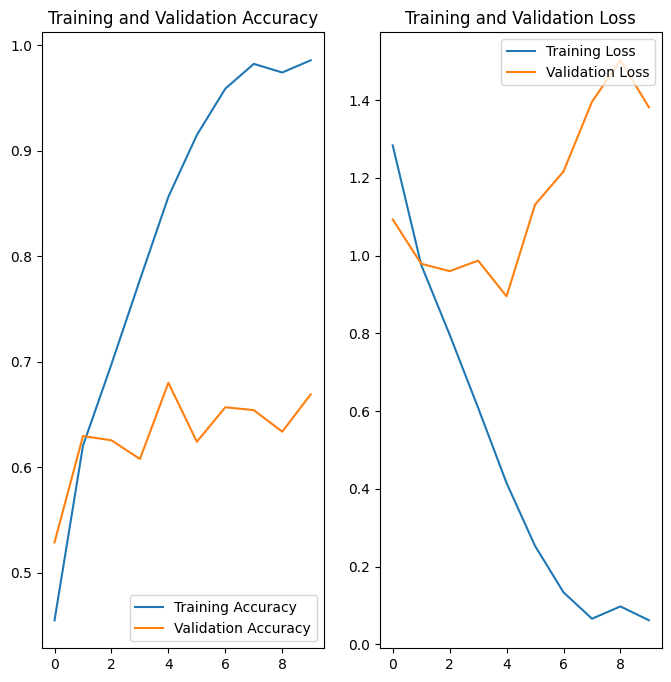

In [ ]:
#Create plots of the loss and accuracy on the training and validation sets:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Data augmentation to avoid overfitting
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

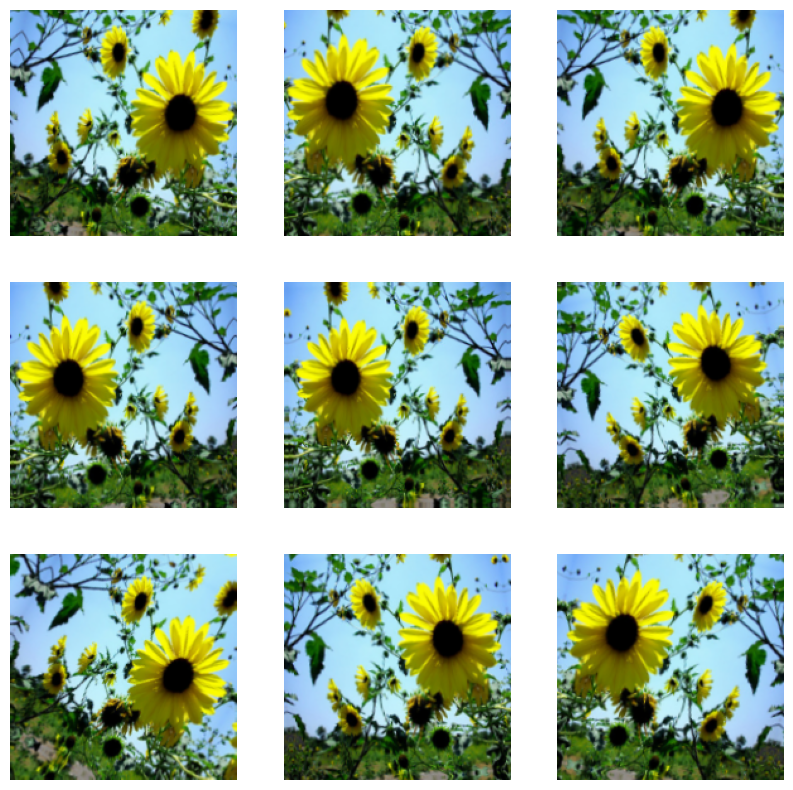

In [ ]:
#Visualize a few augmented examples by applying data augmentation to the same image several times:
#You will add data augmentation to your model before training in the next step.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 5s 33ms/step - loss: 1.3177 - accuracy: 0.4377 - val_loss: 1.1547 - val_accuracy: 0.5313
Epoch 2/15
92/92 [==============================] - 3s 30ms/step - loss: 1.0588 - accuracy: 0.5743 - val_loss: 1.0749 - val_accuracy: 0.5790
Epoch 3/15
92/92 [==============================] - 3s 29ms/step - loss: 0.9468 - accuracy: 0.6386 - val_loss: 0.9232 - val_accuracy: 0.6267
Epoch 4/15
92/92 [==============================] - 3s 29ms/step - loss: 0.8776 - accuracy: 0.6604 - val_loss: 0.8895 - val_accuracy: 0.6567
Epoch 5/15
92/92 [==============================] - 3s 31ms/step - loss: 0.8504 - accuracy: 0.6720 - val_loss: 0.8540 - val_accuracy: 0.6785
Epoch 6/15
92/92 [==============================] - 3s 29ms/step - loss: 0.7877 - accuracy: 0.6907 - val_loss: 0.8199 - val_accuracy: 0.6798
Epoch 7/15
92/92 [==============================] - 3s 29ms/step - loss: 0.7525 - accuracy: 0.7115 - val_loss: 0.7835 - val_accuracy: 0.6839
Epoch 8/15
92

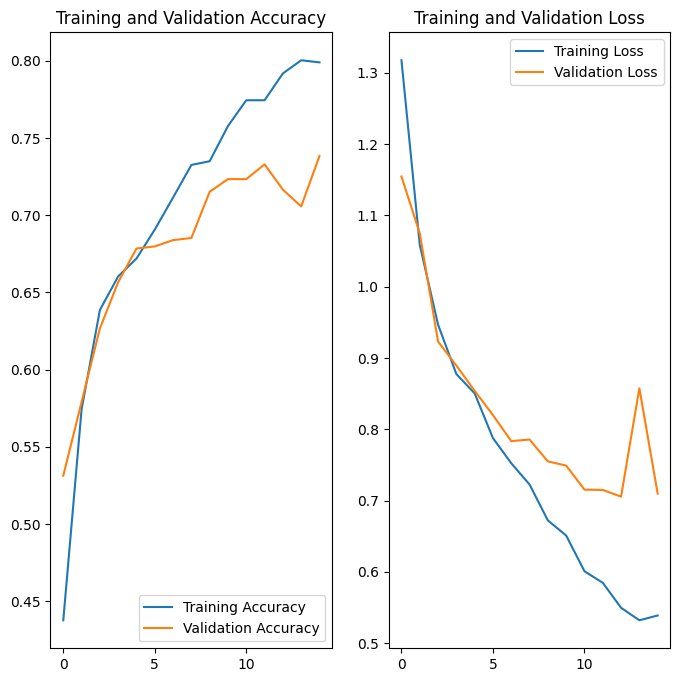

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 385ms/step
This image most likely belongs to sunflowers with a 99.95 percent confidence.


In [ ]:
# Convert the Keras Sequential model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [ ]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [ ]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 99.95 percent confidence.


The prediction generated by the lite model should be almost identical to the predictions generated by the original model:

In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))

1.847744e-06
